## My naive attempt at the titanic competition
#### By Xavier D'Mello https://github.com/xavierdmello

## 1. Prep and clean data

In [29]:
import requests 
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/0fa794be523a10b409a2061e43ae03c419d5ace7/helper_functions.py")
    
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists, skipping download


In [30]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer

kaggle_test_data = pd.read_csv("dataset/test.csv")
data = pd.read_csv("dataset/train.csv")

# Get labels and features
features = ["Pclass", "Sex", "SibSp", "Parch", "Age", "Fare", "Embarked"]
labels = ["Survived"]

# Convert label (Sex) to numerical value. 0 = Female, 1 = Male
le = LabelEncoder()
for col in ['Sex', 'Embarked']:
  le.fit(data[col])
  data[col] = le.transform(data[col])
  kaggle_test_data[col] = le.transform(kaggle_test_data[col])

y = data[labels]
X = data[features]
X_kaggle = kaggle_test_data[features]
X_kaggle_IDs = kaggle_test_data[["PassengerId"]]

# If there are values missing in any row, replace NaN with the column average
imputer = SimpleImputer(strategy='median')
X = imputer.fit_transform(X)
X_kaggle = imputer.transform(X_kaggle)

# Feature Scaling 
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X)
X_kaggle = scaler.transform(X_kaggle)

X, y

(array([[1.        , 1.        , 0.125     , ..., 0.27117366, 0.01415106,
         0.66666667],
        [0.        , 0.        , 0.125     , ..., 0.4722292 , 0.13913574,
         0.        ],
        [1.        , 0.        , 0.        , ..., 0.32143755, 0.01546857,
         0.66666667],
        ...,
        [1.        , 0.        , 0.125     , ..., 0.34656949, 0.04577135,
         0.66666667],
        [0.        , 1.        , 0.        , ..., 0.32143755, 0.0585561 ,
         0.        ],
        [1.        , 1.        , 0.        , ..., 0.39683338, 0.01512699,
         0.33333333]]),
      Survived
 0           0
 1           1
 2           1
 3           1
 4           0
 ..        ...
 886         0
 887         1
 888         0
 889         1
 890         0
 
 [891 rows x 1 columns])

In [31]:
# Load into tensors
import torch
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
# Send to device 
device = "cuda" if torch.cuda.is_available() else "cpu"

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values).type(torch.float32).to(device)
y_test = torch.tensor(y_test.values).type(torch.float32).to(device)

X_kaggle_test = torch.tensor(X_kaggle, dtype=torch.float32).to(device)



X_train[:5], y_train[:5]

(tensor([[0.0000, 1.0000, 0.0000, 0.0000, 0.5665, 0.0556, 0.6667],
         [0.5000, 1.0000, 0.0000, 0.0000, 0.2837, 0.0254, 0.6667],
         [1.0000, 1.0000, 0.0000, 0.0000, 0.3968, 0.0155, 0.6667],
         [1.0000, 1.0000, 0.1250, 0.0000, 0.3214, 0.0153, 0.6667],
         [1.0000, 0.0000, 0.5000, 0.3333, 0.0701, 0.0610, 0.6667]],
        device='cuda:0'),
 tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'))

## 2. Define and train neural network

In [32]:
from torch import nn
from helper_functions import accuracy_fn

torch.manual_seed(42)
model = nn.Sequential(
    nn.Linear(in_features=len(features), out_features=100),
    nn.ReLU(),
    nn.Linear(in_features=100, out_features=len(labels)),
).to(device)

epochs = 451
epochs_list = []
train_loss_list = []
test_loss_list = []
accuracy_list = []
test_accuracy_list = []
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.eval()
    logits = model(X_train)
    acc = accuracy_fn(y_train,torch.round(torch.sigmoid(logits)) )
    
    loss = loss_fn(logits, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.train()
    with torch.inference_mode():
        test_logits = model(X_test)
        test_acc = accuracy_fn(y_test, torch.round(torch.sigmoid(test_logits)))
        test_loss = loss_fn(test_logits, y_test)
        
        train_loss_list.append(loss)
        test_loss_list.append(test_loss)
        epochs_list.append(epoch)
        accuracy_list.append(acc)
        test_accuracy_list.append(test_acc)
        if epoch % 50 == 0:
            print(f"Epoch: {epoch} Train loss: {loss:.5f} Train Acc: {acc:.2f}% Test loss: {test_loss:.5f} Test acc: {test_acc:.2f}%")


Epoch: 0 Train loss: 0.71396 Train Acc: 37.50% Test loss: 0.70426 Test acc: 42.46%
Epoch: 50 Train loss: 0.57722 Train Acc: 69.94% Test loss: 0.58245 Test acc: 70.95%
Epoch: 100 Train loss: 0.49904 Train Acc: 80.20% Test loss: 0.49951 Test acc: 78.77%
Epoch: 150 Train loss: 0.46406 Train Acc: 80.34% Test loss: 0.46296 Test acc: 78.77%
Epoch: 200 Train loss: 0.44644 Train Acc: 80.90% Test loss: 0.44790 Test acc: 78.77%
Epoch: 250 Train loss: 0.43518 Train Acc: 81.46% Test loss: 0.43838 Test acc: 79.33%
Epoch: 300 Train loss: 0.42681 Train Acc: 81.88% Test loss: 0.43186 Test acc: 79.89%
Epoch: 350 Train loss: 0.42027 Train Acc: 82.02% Test loss: 0.42833 Test acc: 80.45%
Epoch: 400 Train loss: 0.41470 Train Acc: 82.44% Test loss: 0.42703 Test acc: 81.01%
Epoch: 450 Train loss: 0.41012 Train Acc: 82.30% Test loss: 0.42633 Test acc: 81.56%


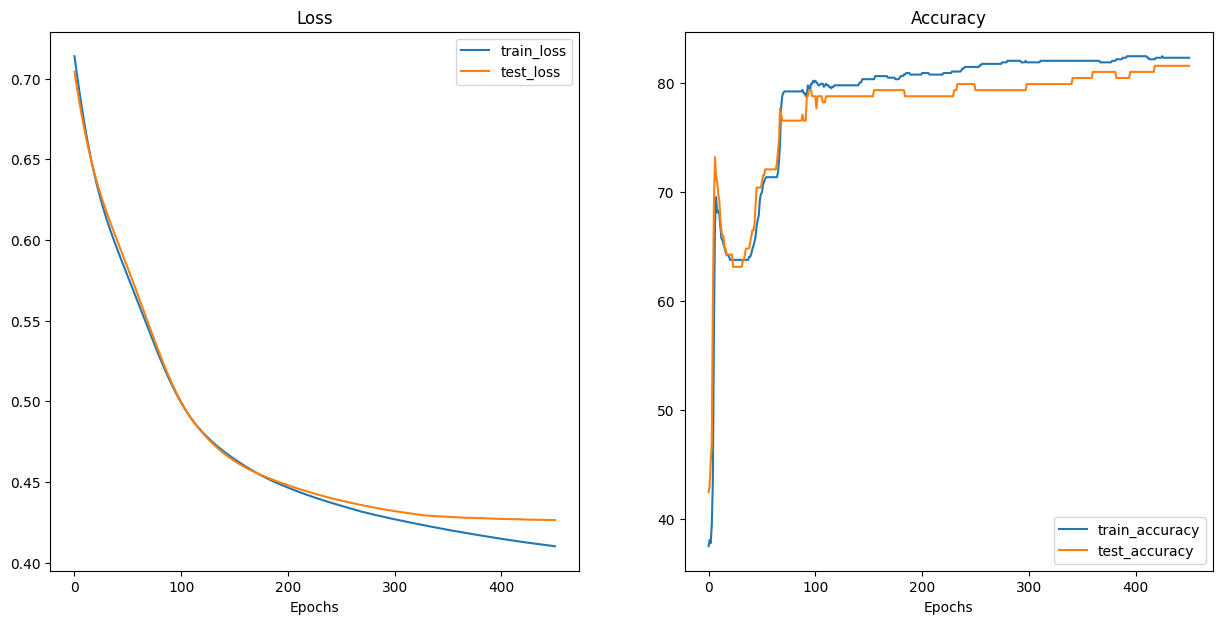

In [33]:
plt.figure(figsize=(15, 7))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs_list, torch.tensor(train_loss_list).detach(), label="train_loss")
plt.plot(epochs_list, torch.tensor(test_loss_list), label="test_loss")
plt.title("Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_list, accuracy_list, label="train_accuracy")
plt.plot(epochs_list, test_accuracy_list, label="test_accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
    

## 3. Run on test data and export results
We'll export a csv to submit to kaggle.

In [34]:
model.eval()
with torch.inference_mode():
    kaggle_logits = model(X_kaggle_test)
    kaggle_preds = torch.round(torch.sigmoid(kaggle_logits))
    
    output = pd.DataFrame({'PassengerId': X_kaggle_IDs.squeeze(), 'Survived': kaggle_preds.type(torch.LongTensor).squeeze()})
    output.to_csv('submission.csv', index=False)
    print("Exported predictions!")

Exported predictions!
